<a href="https://colab.research.google.com/github/cs20m016/cs6910-Assignment-1/blob/main/nesterov_grad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

In [22]:
from keras.datasets import fashion_mnist

In [23]:
(train_X,train_Y), (test_X,test_Y)= fashion_mnist.load_data()

In [24]:
train_X.shape, train_Y.shape

((60000, 28, 28), (60000,))

In [25]:
train_X = train_X[:]/255
test_Y = test_Y[:]/255

In [26]:
train_X=[train_X[i].flatten() for i in range(len(train_X))]
test_X=[test_X[i].flatten() for i in range(len(test_X))]

In [27]:
np.shape(train_X), np.shape(train_Y), np.shape(test_X), np.shape(test_Y)

((60000, 784), (60000,), (10000, 784), (10000,))

In [28]:
train_samples=len(train_X)
test_samples=len(test_X)
xlen=len(train_X[0])
print(xlen)

784


In [29]:
#N: number of inputs
#N = input()
N = 5
#L: number of layers
#L = input()
L = 3
#H = number of hidden layers
Hid = L-1
#K = number of classes
K = 10

In [30]:
def initialize_weights(n_input, n_hidden_layer, n_output,neurons_hl):
    W = list()
    W.append([[random.random() for j in range(n_input)]for i in range(neurons_hl)])
    for i in range(n_hidden_layer-1):
        W.append([[random.random() for j in range(neurons_hl)]for i in range(neurons_hl)])
    W.append([[random.random() for j in range(neurons_hl)]for i in range(n_output)])
    return W

In [31]:
def initialize_bias(n_input, n_hidden_layer, n_output,n_neurons):
    b=list()
    for i in range(n_hidden_layer):
        b.append([random.random() for i in range(n_neurons)])
    b.append([random.random() for i in range(n_output)])
    return b

In [32]:
def sigmoid(a):
  h = []
  for a1 in a:
    h.append(1.0/(1.0 + np.exp(-a1)))
  return h

In [33]:
def softmax(a):
  y = []
  sum = 0
  for a1 in a:
    sum+= np.exp(a1)
  for a1 in a:
    y.append(np.exp(a1)/sum)
  return y

In [34]:
def feed_forward_prop(input,W,b,L):
  H=[]
  A=[]
  h=input
  H.append(h)
  A.append([0])
  for i in range(1,L):
      a=b[i-1]+np.matmul(W[i-1],h)
      A.append(a)
      h=sigmoid(a)
      H.append(h)
  aL=b[L-1]+np.matmul(W[L-1],h)
  A.append(aL)
  hL=softmax(aL)
  H.append(hL)
  y_hat = hL
  return H,A,y_hat

In [35]:
def cmp(e):
  g=1.0/(1.0 + np.exp(-e))
  return g*(1-g)

In [36]:
def diff_sigmoid(a):
    res=[]
    for el in a:
      res.append(cmp(el))
    return res

In [37]:
def back_propogation(H,A,y_hat,label,W):
    W_grad=list()
    B_grad=list()
    one_hot_y=np.zeros(K)
    one_hot_y[label]+=1
    ak_grad = y_hat-one_hot_y
    for k in range(L,0,-1):
        w_grad=np.matmul(np.matrix(ak_grad).T,np.matrix(H[k-1]))
        W_grad.append(w_grad)
        B_grad.append(ak_grad)
        if k != 1:
            h_grad=np.matmul(np.transpose(W[k-1]),ak_grad)
            ak_grad=np.multiply(h_grad,diff_sigmoid(A[k-1]))
    return W_grad,B_grad

In [38]:
eta=0.001
gamma = 0.9

In [41]:
def nesterov_accelerated_gradient_descent():
    t=0
    max_iterations=5
    W= initialize_weights(xlen,L-1,K,N)
    B= initialize_bias(xlen,L-1,K,N)
    loss=list()
    prev_vw=list()
    prev_bw=list()
    for l in range(L):
      prev_vw.append(np.zeros(shape=np.shape(W[l])).tolist())
      prev_bw.append(np.zeros(shape=np.shape(B[l])).tolist())
    while (t<max_iterations):
      wgrad=list()
      bgrad=list()
      for l in range(L):
          wgrad.append(np.zeros(shape=np.shape(W[l])).tolist())
          bgrad.append(np.zeros(shape=np.shape(B[l])).tolist())
      v_w = list()
      v_b = list()
      for l in range(L):
          v_w.append(np.multiply(gamma,prev_vw[l]))
          v_b.append(np.multiply(gamma,prev_bw[l]))
      
      W_v_w = list()
      B_v_b = list()

      for l in range(L):
          W_v_w.append((np.matrix(W[l])-np.matrix(v_w[l])).tolist())
          B_v_b.append(np.subtract(B[l],v_b[l]))

      for i in range(train_samples):
        for l in range(L):
            H,A,y_hat=feed_forward_prop(train_X[i],W_v_w,B_v_b,L)
            W_grad,B_grad=back_propogation(H,A,y_hat,train_Y[i],W_v_w)
            W_grad=W_grad[::-1]
            B_grad=B_grad[::-1]
            loss.append(-math.log(y_hat[train_Y[i]]))
      
        for l in range(L):
          v_w.append(np.multiply(gamma,prev_vw[l])+np.multiply(eta,W_grad[l]).tolist())
          v_b.append(np.multiply(gamma,prev_bw[l])+np.multiply(eta,B_grad[l]).tolist())
        for l in range(L):
          W[l]=(np.matrix(W[l])-np.matrix(v_w[l])).tolist()
          B[l]=np.subtract(B[l],v_b[l]) 
        for l in range(L):
          prev_vw[l] = v_w[l]
          prev_bw[l] = v_b[l]

      t=t+1
      print('Epoch',t)
    return W,B,loss

In [42]:
W_n,B_n,loss_n = nesterov_accelerated_gradient_descent()

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


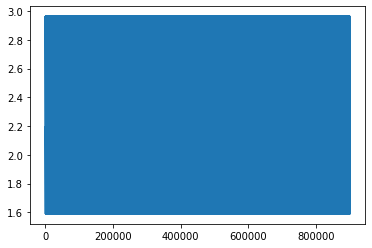

In [43]:
plt.plot(np.arange(1,len(loss_n)+1),loss_n)